In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from string import punctuation
import torch
from torch import nn
import re
from math import log
from datasets import load_dataset_builder
from datasets import load_dataset


/home/clousty8/.local/share/virtualenvs/nlp2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
vader_lexicon = pd.read_csv("vader_lexicon.csv", delimiter="\t", names=["symbols", "grade", "??", "vector"])
vader_lexicon

,symbols,grade,??,vector
0,$:,-1.5,0.80623,"[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]"
1,%),-0.4,1.01980,"[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]"
2,%-),-1.5,1.43178,"[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]"
3,&-:,-0.4,1.42829,"[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]"
4,&:,-0.7,0.64031,"[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]"
...,...,...,...,...
7515,}:,-2.1,0.83066,"[-1, -1, -3, -2, -3, -2, -2, -1, -3, -3]"
7516,}:(,-2.0,0.63246,"[-3, -1, -2, -1, -3, -2, -2, -2, -2, -2]"
7517,}:),0.4,1.42829,"[1, 1, -2, 1, 2, -2, 1, -1, 2, 1]"
7518,}:-(,-2.1,0.70000,"[-2, -1, -2, -2, -2, -4, -2, -2, -2, -2]"


In [5]:
# load data set
ds_builder = load_dataset_builder("imdb")
dataset = load_dataset("imdb")

all_data = {}

def clean_data(text_data):
    text_data = text_data.str.lower()
    text_data = text_data.str.replace("[" + punctuation + "]( |$)", "", regex=True)
    return text_data

for type in dataset.keys():
        
    text_data = pd.Series(dataset[type]["text"])

    text_data = clean_data(text_data=text_data)
    all_data[type] = pd.concat([text_data, pd.Series(dataset[type]["label"])], axis=1)
    all_data[type].columns=["text", "label"]
    
    
data = all_data["train"]
data

Dataset imdb downloaded and prepared to /home/clousty8/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 791.43it/s]


,text,label
0,i rented i am curious-yellow from my video sto...,0
1,"""i am curiousyellowis a risible and pretentiou...",0
2,if only to avoid making this type of film in t...,0
3,this film was probably inspired by godard's ma...,0
4,ohbrother...after hearing about this ridiculou...,0
...,...,...
24995,a hit at the time but now better categorised a...,1
24996,i love this movie like no otheranother time i ...,1
24997,this film and it's sequel barry mckenzie holds...,1
24998,'the adventures of barry mckenziestarted life ...,1


In [32]:

data_set = ["I don't really know where this came from, but this movie, which was very clearly created to be for kids, has some real material built around solid bones. And that wolf was genuinely unnerving.", "meh; i didn't love it. it lost my attention eventually."]
data_set = pd.DataFrame(data, columns=["text", "label"])
data_set["text"] = data_set["text"].str.lower()

def word_mood(word : str)->int:
    word_row = vader_lexicon.loc[vader_lexicon["symbols"] == word]
    if word_row.empty:
        return 0
    if word_row.iloc[0]["grade"] >= 1:
        return 1
    elif word_row.iloc[0]["grade"] <= -1:
        return -1
    return 0

data_set["word list"] = data_set["text"].apply(lambda text : re.split("[" + punctuation + " ]", text))
data_set["no?"] = data_set["word list"].apply(lambda word_list : "no" in word_list).astype("int")
data_set["pronoun"] = data_set["word list"].apply(lambda word_list : word_list.count("i") + word_list.count("you"))
data_set["!?"] = data_set["text"].str.contains("!").astype("int")
data_set["log(nb word)"] = data_set["word list"].apply(len).apply(np.log)
data_set["word list"] = data_set["word list"].apply(lambda word_list : map(word_mood, word_list))
data_set["good_mood"] = data_set["word list"].apply(lambda word_list : list(word_list).count(1))
data_set["bad_mood"] = data_set["word list"].apply(lambda word_list : word_list.count(-1))



# np.array([vectorize_text(text) for text in data_set]).T)
data_set


: 

: 

data_set["no?"] = data_set["text"]


def vectorize_text(text : str) -> np.array:
    word_list : list = re.split("[" + punctuation + " ]", text)
    print(word_list)
    word_mood_list = list(map(word_mood, word_list))
    print(word_mood_list)
    
    
    
    return pd.DataFrame({
        "no?" : 1 if "no" in word_list else 0,
        "pronoun" : word_list.count("i") + word_list.count("you"),
        "!?" : 1 if "!" in text else 0,
        "log(nb word)" : log(len(word_list)),
        "good mood" : word_mood_list.count(1),
        "bad mood" : word_mood_list.count(-1),
    })

## Generating the dataset

We generate a mock dataset of points within two gausians and their labels.

In [49]:
"""Useless for us"""

# Forcing the random seed for reproductibility
np.random.seed(seed=42)
# Generating distributions
first_distribution = np.random.normal(-2.0, 1.0, size=(10000, 2))
second_distribution = np.random.normal(2.0, 1.0, size=(10000, 2))

all_points = np.concatenate((first_distribution, second_distribution), axis=0)
# Labels
labels = [0] * first_distribution.shape[0] + [1] * second_distribution.shape[0]
"""end useless"""


In [50]:
all_points.shape, len(labels)

((20000, 2), 20000)

In [51]:
df = pd.DataFrame()
df["x"] = all_points[:, 0]
df["y"] = all_points[:, 1]
df["label"] = labels
df.head()

,x,y,label
0,-1.503286,-2.138264,0
1,-1.352311,-0.476970,0
2,-2.234153,-2.234137,0
3,-0.420787,-1.232565,0
4,-2.469474,-1.457440,0


<Axes: xlabel='x', ylabel='y'>

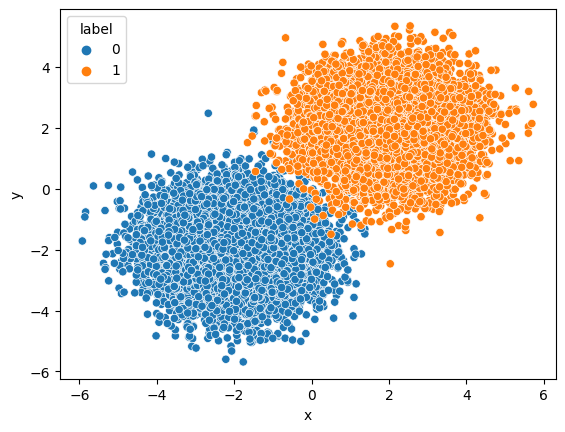

In [52]:
sns.scatterplot(data=df, x="x", y="y", hue="label")

## Train, test, and validation split

We need a test set to evaluate our final model, and a validation set to make sure we don't overfit to the training data.

In [53]:
all_points = torch.tensor(all_points, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    all_points,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42,
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42,
)

## Logisitic regression classifier

In [54]:
class LogisticRegression(nn.Module):
    """A logistic regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        output_layer = nn.Sigmoid() if nb_classes == 1 else nn.Softmax()
        self.classifier = torch.nn.Sequential(
            nn.Linear(input_dim, nb_classes),
            output_layer,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of activation function.
        """
        return self.classifier(x)

## Training the model

In [55]:
model = LogisticRegression(2, 1)
criterion = nn.BCELoss()  # Binary cross entropy
# Stochastic gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)

In [56]:
%%time

n_epochs = 1000

# Keeping an eye on the losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(n_epochs):
    # Setting all gradients to zero.
    optimizer.zero_grad()

    # Sending the whole training set through the model.
    predictions = model(X_train)
    # Computing the loss.
    loss = criterion(predictions, y_train)
    train_losses.append(loss.item())
    if epoch % 100 == 0:
        print(loss)
    # Computing the gradients and gradient descent.
    loss.backward()
    optimizer.step()

    # When computing the validation loss, we do not want to update the weights.
    # torch.no_grad tells PyTorch to not save the necessary data used for
    # gradient descent.
    with torch.no_grad():
        predictions = model(X_valid)
        loss = criterion(predictions, y_valid)
        test_losses.append(loss)

tensor(0.3007, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1894, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1715, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1674, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1664, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1662, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1661, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1661, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1661, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1661, grad_fn=<BinaryCrossEntropyBackward0>)
CPU times: user 2.72 s, sys: 0 ns, total: 2.72 s
Wall time: 683 ms


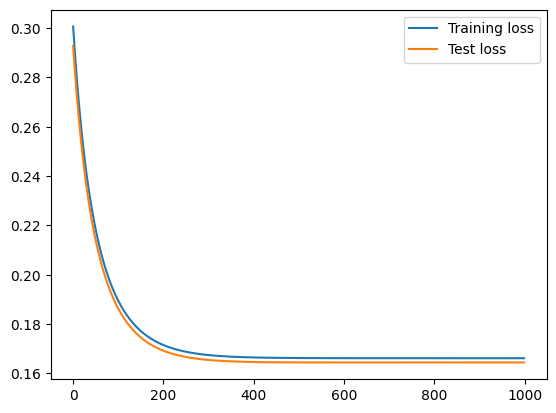

In [57]:
# Checking the losses
plt.plot(np.arange(len(train_losses)), train_losses, label="Training loss")
plt.plot(np.arange(len(test_losses)), test_losses, label="Test loss")
plt.legend()

In [58]:
# Computing the accuracy for our 3 splits.
with torch.no_grad():
    p_train = model(X_train)
    p_train = np.round(p_train.numpy())
    training_accuracy = np.mean(p_train == y_train.numpy())
    p_valid = model(X_valid)
    p_valid = np.round(p_valid.numpy())
    valid_accuracy = np.mean(p_valid == y_valid.numpy())
    p_test = model(X_test)
    p_test = np.round(p_test.numpy())
    test_accuracy = np.mean(p_test == y_test.numpy())
print(training_accuracy, valid_accuracy, test_accuracy)

0.99734375 0.9975 0.99775


In [59]:
# Predicting new samples
model(torch.tensor([[-2.0, -1.5], [2, 1.5]], dtype=torch.float32))

tensor([[0.1586],
        [0.8417]], grad_fn=<SigmoidBackward0>)

In [60]:
# Looking at the model's weights and bias.
model.classifier[0].state_dict()["weight"], model.classifier[0].state_dict()["bias"]

(tensor([[0.4767, 0.4775]]), tensor([0.0013]))

## Training model, but better

The best practice with PyTorch is to return the logits and not the results of the activation function. Doing so allows to use an [implementation trick](https://en.wikipedia.org/wiki/LogSumExp) which gives better stability at training. The following code uses this trick. It removes the activation function from the model and uses the corresponding ...WithLogitsLoss function.

In [61]:
class LinearRegression(nn.Module):
    """A linear regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        self.linear = nn.Linear(input_dim, nb_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of the linear layer.
        """
        return self.linear(x)

In [62]:
model = LinearRegression(2, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)

In [63]:
%%time

n_epochs = 1000

# Keeping an eye on the losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(n_epochs):
    # Setting all gradients to zero.
    optimizer.zero_grad()

    # Sending the whole training set through the model.
    predictions = model(X_train)
    # Computing the loss.
    loss = criterion(predictions, y_train)
    train_losses.append(loss.item())
    if epoch % 100 == 0:
        print(loss)
    # Computing the gradients and gradient descent.
    loss.backward()
    optimizer.step()

    # When computing the validation loss, we do not want to update the weights.
    # torch.no_grad tells PyTorch to not save the necessary data used for
    # gradient descent.
    with torch.no_grad():
        predictions = model(X_valid)
        loss = criterion(predictions, y_valid)
        test_losses.append(loss)

tensor(0.1782, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1666, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1654, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1657, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1659, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1660, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1661, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1661, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1661, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1661, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
CPU times: user 1.56 s, sys: 7.24 ms, total: 1.56 s
Wall time: 395 ms


Notice how the training was faster. This is due to the implementation trick.

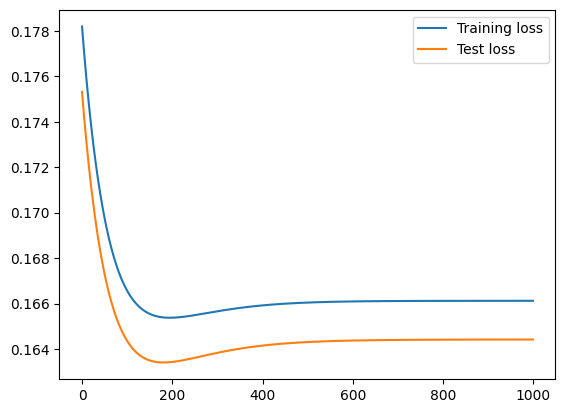

In [64]:
plt.plot(np.arange(len(train_losses)), train_losses, label="Training loss")
plt.plot(np.arange(len(test_losses)), test_losses, label="Test loss")
plt.legend()

In [65]:
# Note that we need to use a sigmoid on the output now.
with torch.no_grad():
    p_train = torch.sigmoid(model(X_train))
    p_train = np.round(p_train.numpy())
    training_accuracy = np.mean(p_train == y_train.numpy())
    p_valid = torch.sigmoid(model(X_valid))
    p_valid = np.round(p_valid.numpy())
    valid_accuracy = np.mean(p_valid == y_valid.numpy())
    p_test = torch.sigmoid(model(X_test))
    p_test = np.round(p_test.numpy())
    test_accuracy = np.mean(p_test == y_test.numpy())
print(training_accuracy, valid_accuracy, test_accuracy)

0.99734375 0.9975 0.99775


In [66]:
# Predicting new samples, we need to use a sigmoid on top of the output.
torch.sigmoid(model(torch.tensor([[-2.0, -1.5], [2, 1.5]], dtype=torch.float32)))

tensor([[0.1588],
        [0.8418]], grad_fn=<SigmoidBackward0>)